In [1]:
# MNIST test dataset
from tensorflow.keras.datasets import mnist

In [2]:
# import helper library
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# import dataset
(trainx, trainy), (testx, testy) = mnist.load_data()

In [4]:
# seeing the shapes of imported dataset
trainx.shape, trainy.shape, testx.shape, testy.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

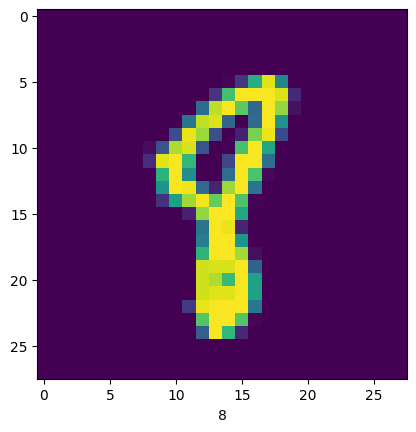

In [5]:
def choose_random_train():
    random_number = np.random.randint(0, 60000)
    sample_X = trainx[random_number]
    sample_y = trainy[random_number]
    return sample_X, sample_y, random_number

random_X, random_y, _ = choose_random_train()
plt.imshow(random_X)
plt.xlabel(random_y)

cursor = 0
def batch_generator_1000():
    global cursor
    print(cursor)
    x_batch = trainx[cursor:cursor+1000]
    y_batch = trainy[cursor:cursor+1000]
    cursor += 1000
    cursor %= 60000
    return x_batch, y_batch

# aax, aay = batch_generator_1000()
# aax.shape, aay.shape

### Making the layers

##### Layers
- Each layers maintains following associated datatypes:
    - Information types
        - name: Name of the layer
        - parameters_count: Number of parameters of the layer
    - Useful types
        - Depends on the type of layer:
            - Eg: For weights layer, it's the weight matrix
            - Eg: For bias layer, it's the bias vector
            - Eg: For the activation layer, it is nothing
        - They can be abstracted away for the user of the layer

- Each layer should have the following functions
    - Apply (input) -> output
        - It applies the layer's operation to it's input to give an output
    - Input gradient (output gradient, input value, output value) -> gradient values for input
        - It calculates the gradient for the input given the gradient values for the output.
        - It takes the output gradient values, it's input values and it's output values, if it saves the computations
    - Parameter gradient (output gradient, input value, output value) -> gradient values for parameters
        - It calculates the gradient for the parameters using the output gradients, input values and output values
        - If the layer doesn't have any parameters, it has to output zero (because we will sum the gradients, and we need something to sum it)
    - dummy gradient () -> a zero of shape of parameters
        - a zero gradient value of shape of the parameters
    - learn (parameter gradient, learning rate)
        - It modifies the parameter given the gradient of the parameters and the learning rate

In [6]:
# helper function
def expand_dims_and_transpose(x):
    return np.transpose(np.expand_dims(x, 0))
def expand_dims(x):
    return np.expand_dims(x, 0)

# layers
class Flattener:
    def __init__(self, shape):
        self.name = f"Flattener                 : {shape} to {np.prod(shape)}\n"
        self.param_count = 0

        self.from_shape = shape
    
    def apply(self, input_value):
        return np.ndarray.flatten(input_value)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        return np.ndarray.reshape(output_gradient, self.from_shape)
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class Scaler:
    def __init__(self, scale_factor):
        self.name = f"Scaler with scale factor {scale_factor}"
        self.param_count = 0

        self.scale_factor = scale_factor
    
    def apply(self, input_value):
        return self.scale_factor * input_value
    
    def input_gradient(self, output_gradient, input_value=None, output_value = None):
        return self.scale_factor * output_gradient
    
    def parameter_gradient(self, output_gradient, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class Weights:
    def __init__(self, input_size, output_size):
        self.name = f"Weights layer             : {input_size} to {output_size}"
        self.param_count = input_size * output_size
        
        # We create a transposed weights because input is a row vector
        self.weights = np.random.rand(input_size, output_size) - .5

    def apply(self, input_value):
        return np.matmul(input_value, self.weights)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        transposed_output_gradient = expand_dims_and_transpose(output_gradient)
        return np.transpose(np.matmul(self.weights, transposed_output_gradient))[0,:]
    
    def parameter_gradient(self, output_gradient, input_value, output_value=None):
        transposed_input = expand_dims_and_transpose(input_value)
        # print(np.shape(transposed_input), np.shape(output_gradient))
        return np.matmul(transposed_input, expand_dims(output_gradient))
    
    def dummy_gradient(self):
        return np.zeros(np.shape(self.weights))
    
    def learn(self, parameter_gradient_value, learning_rate):
        self.weights -= learning_rate * parameter_gradient_value

class Biases:
    def __init__(self, input_size):
        self.name = f"Biases layer              : {input_size}"
        self.param_count = input_size

        # We create a row vector of biases because input is a row vector
        self.biases = np.random.rand(input_size) - .5
    
    def apply(self, input_value):
        return input_value + self.biases
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        return output_gradient
    
    def parameter_gradient(self, output_gradient, input_value=None, output_value=None):
        return output_gradient
    
    def dummy_gradient(self):
        return np.zeros(np.shape(self.biases))
    
    def learn(self, parameter_gradient_value, learning_rate):
        self.biases -= learning_rate * parameter_gradient_value

class ReluActivation:
    def __init__(self):
        self.name = f"ReLU Activation\n"
        self.param_count = 0

        # we create a vectorized function for activaton
        self.activation_function = np.vectorize(lambda x: 0 if x < 0 else x)
        # similarly we create a vectorized function for gradient
        self.gradient_function = np.vectorize(lambda x: 0 if x < 0 else 1)
    
    def apply(self, input_value):
        return self.activation_function(input_value)
    
    def input_gradient(self, output_gradient, input_value, output_value=None):
        return np.multiply(output_gradient, self.gradient_function(input_value))
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class SoftmaxActivationOnlyWhenNeeded:
    def __init__(self, need=False):
        self.name = f"Softmax Activation, Activated:{need}\n"
        self.param_count = 0
        self.need = need
    
    def actual_apply(self, input_value):
        maximum = np.max(input_value)
        new_data = np.exp(input_value-maximum)
        denominator = np.sum(new_data)
        return new_data/denominator
        
    
    def apply(self, input_value):
        if self.need:
            return self.actual_apply(input_value)
        return input_value
    
    def actual_input_gradient(self, output_gradient, input_value, output_value=None):
        size = len(output_value)
        if output_value == None:
            output_value = self.actual_apply(input_value)
        magic_matrix = np.diag(output_value) - np.matmul(np.transpose(output_value), output_value)
        return np.matmul(output_gradient, magic_matrix)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        if self.need:
            return self.actual_input_gradient(output_gradient, input_value, output_value)
        return output_gradient
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

In [7]:
# dataset transformation
class OneHotEncoder:
    def __init__(self, input_size):
        self.name = "One hot encoder of size : {input_size}"
        self.size = input_size
    
    def __call__(self, number):
        output = np.zeros(self.size)
        output[number] = 1
        return output

class Identity:
    def __init__(self):
        self.name = "None"
    def __call__(self, x):
        return x

### Making the Loss Function
##### Loss function
- Each loss function has following data types
    - Name: Name of the loss function.

- Each loss function should implement the following methods
    - Apply(prediction, ground_truth) -> loss value
        - It calculates the required loss function.
    - Call(prediction, gournd_truth) -> loss value
        - It calls the apply function under the hood.
    - Prediction gradient(prediction, ground_truth) -> gradient values for output
        - It returns the gradient value for the loss wrt prediction value.
        - To calculate it, it is supplied with the prediction value and the ground truth.

In [8]:
def softmax_function(input_value):
    maximum = np.max(input_value)
    new_data = np.exp(input_value-maximum)
    denominator = np.sum(new_data)
    return new_data/denominator

class CrossEntropyLossFunctionFromLogits:
    def __init__(self):
        self.name = "Cross Entropy Loss Function from the logits"
        self.loss_function = softmax_function
    
    def apply(self, prediction, ground_truth):
        # ground_truth_class = np.argmax(ground_truth)
        # return -np.log(softmax_function(prediction)[ground_truth_class])

        softmax_output = softmax_function(prediction)
        return np.sum(np.multiply(-ground_truth, np.log(softmax_output)))
    
    def __call__(self, prediction, ground_truth):
        return self.apply(prediction, ground_truth)
    
    def prediction_gradient(self, prediction, ground_truth):
        return np.sum(ground_truth)*softmax_function(prediction) - ground_truth


### Making the model
##### Sequential model
- Each sequential model should have following data types
    - Information types
        - Name: Name of the model
    - Useful types
        - Layers: A list of the sequential layers
        - Loss function : The function that defines the loss
        - Dataset transformation : The transformation that is applied to the output of the dataset

        - Cumulative parameter gradients for all layers
        - 
- Each sequential model should implement the following methods
    - Informational / debug
        - representation
    - Useful
        - inference (input) -> output
            - For simple inference
        - Reset gradient
            - To reset the parameter gradients for all layers
        - forward propagation (input) -> output
            - For simple layer by layer forward propagation
            - Saves the input to each layer
            - Saves the last output
            - Prepares for the back propagation
        - Back propagation (output gradients) ->
            - Layer by layer back propagation calculating the parameter gradients at each step, and back-propagating the intermediate gradients
            - Sums the parameter gradients
        - input gradients
            - To calculate the gradient of the input given the gradient of the output

    

In [9]:
class Sequential_Model:
    def __init__(self, layers, loss_function, name="Sequential Model",  dataset_transformation=Identity()):
        self.name = name

        self.layers = layers
        self.loss_function = loss_function
        self.dataset_transformation = dataset_transformation
        self.param_count = sum(layer.param_count for layer in layers)
        self.last_loss = 0
    
    def inference(self, input_value):
        last_output = input_value
        for layer in self.layers:
            last_output = layer.apply(last_output)
        return last_output

    def __call__(self, input_value):
        return self.inference(input_value)

    def reset_gradient(self):
        self.parameter_gradients = [layer.dummy_gradient() for layer in self.layers]
        self.last_loss = 0
    
    def forward_propagation(self, input_value):
        self.last_inputs = []

        last_input = input_value
        self.last_inputs.append(last_input)
        for layer in self.layers:
            last_input = layer.apply(last_input)
            self.last_inputs.append(last_input)
        return last_input
    
    def back_propagation(self, output_gradient):
        last_gradient = output_gradient
        last = len(self.layers) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            input_value = self.last_inputs[i]
            output_value = self.last_inputs[i+1]
            parameter_gradient = layer.parameter_gradient(last_gradient, input_value, output_value)

            # save cumulative gradients
            self.parameter_gradients[i] += parameter_gradient

            last_gradient = layer.input_gradient(last_gradient, input_value, output_value)
        return last_gradient
    
    def input_gradients(self, output_gradient):
        last = len(self.layers()) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            output_gradient = layer.input_gradient(output_gradient, self.last_inputs[i], self.last_inputs[i+1])
        return output_gradient
    
    def see_dataset_for_training(self, input_dataset, output_dataset):
        ground_truth = self.dataset_transformation(output_dataset)
        prediction = self.forward_propagation(input_dataset)
        prediction_gradient = self.loss_function.prediction_gradient(prediction, ground_truth)
        last_gradient = self.back_propagation(prediction_gradient)
        self.last_loss += self.loss_function(prediction, ground_truth)
        return last_gradient

    def make_model_learn(self, learning_rate):
        last = len(self.layers) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            layer.learn(self.parameter_gradients[i], learning_rate)
        pass

    def get_loss(self):
        return self.last_loss
    
    def __repr__(self):
        representation = f"{self.name}\n\n" 
        i = 0
        for layer in self.layers:
            i += 1
            representation += f"{i}. {layer.name}\n"
        representation += f"Total parameters = {self.param_count}\n"
        representation += f"Loss function = {self.loss_function.name}\n"
        return representation
        

        
            

In [10]:
# Building the model

MnistClassificationModel = Sequential_Model([
        Scaler(scale_factor=(1/255)),
        Flattener(shape=(28,28)),
    
        Weights(28*28, 400),
        Biases(400),
        ReluActivation(),
    
        Weights(400, 200),
        Biases(200),
        ReluActivation(),

        Weights(200, 100),
        Biases(100),
        ReluActivation(),
    
        Weights(100, 10),
        Biases(10),
    
        SoftmaxActivationOnlyWhenNeeded(),
    ],
    loss_function=CrossEntropyLossFunctionFromLogits(),
    name="Simple MNIST handwritten digit dataset classifier",
    dataset_transformation=OneHotEncoder(10)
)
# Reset cursor for training dataset if model is reinstiated
cursor = 0
losses = []
# also reset the loss, because when model is reinstated training is gone, and so are losses

print(MnistClassificationModel)
# output = MnistClassificationModel(random_X)
# print(output)
# print(softmax_function(output))


Simple MNIST handwritten digit dataset classifier

1. Scaler with scale factor 0.00392156862745098
2. Flattener                 : (28, 28) to 784

3. Weights layer             : 784 to 400
4. Biases layer              : 400
5. ReLU Activation

6. Weights layer             : 400 to 200
7. Biases layer              : 200
8. ReLU Activation

9. Weights layer             : 200 to 100
10. Biases layer              : 100
11. ReLU Activation

12. Weights layer             : 100 to 10
13. Biases layer              : 10
14. Softmax Activation, Activated:False

Total parameters = 415310
Loss function = Cross Entropy Loss Function from the logits



Simple MNIST handwritten digit dataset classifier

1. Scaler with scale factor 0.00392156862745098
2. Flattener                 : (28, 28) to 784

3. Weights layer             : 784 to 400
4. Biases layer              : 400
5. ReLU Activation

6. Weights layer             : 400 to 200
7. Biases layer              : 200
8. ReLU Activation

9. Weights layer             : 200 to 100
10. Biases layer              : 100
11. ReLU Activation

12. Weights layer             : 100 to 10
13. Biases layer              : 10
14. Softmax Activation, Activated:False

Total parameters = 415310
Loss function = Cross Entropy Loss Function from the logits



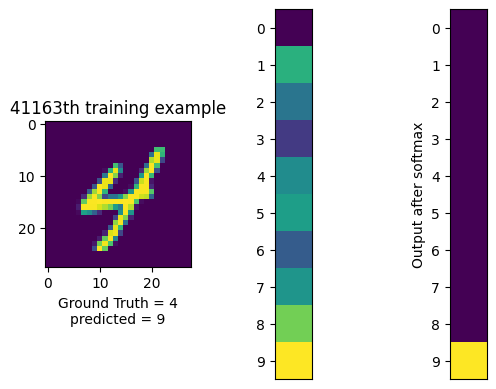

Logits output =  [-103.7086595    28.65665434  -22.56082683  -68.21599042   -2.49947569
   13.2884911   -42.62651196    5.23269816   60.7160162   105.03541726]
Softmax output =  [2.20596862e-91 6.74721777e-34 3.85172506e-56 5.72624151e-76
 1.98696117e-47 1.42828948e-40 7.43428067e-65 4.53137301e-44
 5.65364684e-20 1.00000000e+00]
Loss value for this example =  -271413.162710373


/var/folders/wt/vxbrslkx19g4hvktspqbdxcm0000gn/T/ipykernel_62389/2148852362.py:17: RuntimeWarning: overflow encountered in scalar negative
  return np.sum(np.multiply(-ground_truth, np.log(softmax_output)))


In [11]:
def model_tester(print_outputs=False):
    rx, ry, n = choose_random_train()
    prediction = (MnistClassificationModel(rx))

    plt.subplot(1,3,1)
    plt.imshow(rx)
    plt.xlabel(f"Ground Truth = {ry}\npredicted = {np.argmax(prediction)}")
    plt.title(f"{n}th training example")

    plt.subplot(1,3,2)
    plt.imshow(np.reshape(prediction, (-1,1)))
    plt.yticks(np.arange(10))
    plt.xticks([])
    
    plt.subplot(1,3,3)
    plt.imshow(np.reshape(softmax_function(prediction), (-1, 1)))
    plt.yticks(np.arange(10))
    plt.xticks([])
    plt.ylabel("Output after softmax")

    plt.show()
    if print_outputs:
        print("Logits output = ", prediction)
        print("Softmax output = ", softmax_function(prediction))
        print("Loss value for this example = ", MnistClassificationModel.loss_function(prediction, ry))

print(MnistClassificationModel)
model_tester(True)


======= Epoch : 1 =======
Initial Loss = 0
0
Loss after training = 61578.29296683928


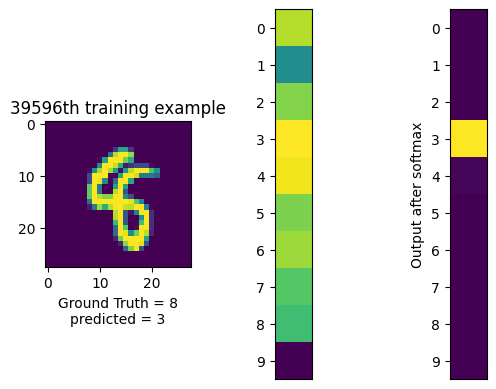

Logits output =  [  20.23733264  -64.62787631    4.67176629   44.16398001   39.7464824
    1.87234764   12.99416664  -11.94172689  -20.70587205 -168.71260792]
Softmax output =  [4.01403297e-11 5.58584631e-48 6.97495427e-18 9.88079430e-01
 1.19205700e-02 4.24394056e-19 2.87021157e-14 4.25003933e-25
 6.64007631e-29 3.49674847e-93]
Loss value for this example =  -144847.30891985618

======= Epoch : 2 =======
Initial Loss = 61578.29296683928
1000


/var/folders/wt/vxbrslkx19g4hvktspqbdxcm0000gn/T/ipykernel_62389/2148852362.py:17: RuntimeWarning: overflow encountered in scalar negative
  return np.sum(np.multiply(-ground_truth, np.log(softmax_output)))


Loss after training = 62093.60221033479


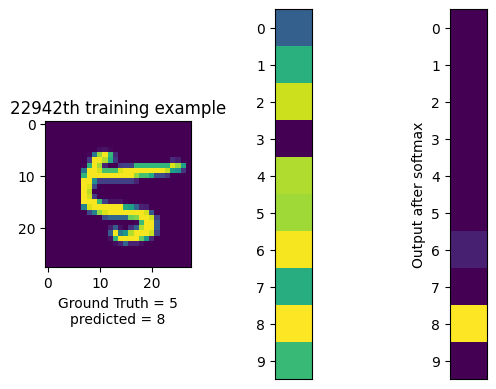

Logits output =  [-100.45550552  -37.1102914    19.15306731 -159.59858181   10.49250255
    6.08795092   31.2314259   -38.84076416   33.64268545  -28.76317187]
Softmax output =  [5.30380538e-59 1.71816366e-31 4.67660562e-07 1.09414758e-84
 8.10392223e-11 9.90427737e-13 8.23180804e-02 3.04459659e-32
 9.17681452e-01 7.24723725e-28]
Loss value for this example =  -150963.09325762835

======= Epoch : 3 =======
Initial Loss = 62093.60221033479
2000
Loss after training = 54524.643405111965


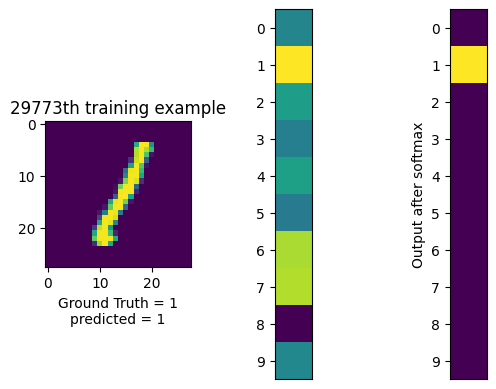

Logits output =  [-14.96899315  81.39947676   2.49939829 -19.57171324   4.60899694
 -22.68783672  58.93959944  60.86981613 -95.81974625 -13.34694965]
Softmax output =  [1.40509371e-42 9.99999999e-01 5.42164778e-35 1.40854054e-44
 4.47011147e-34 6.24387388e-46 1.76116164e-10 1.21361707e-09
 1.08310201e-77 7.11458926e-42]
Loss value for this example =  -196878.54335029793

======= Epoch : 4 =======
Initial Loss = 54524.643405111965
3000
Loss after training = 44044.44495627381


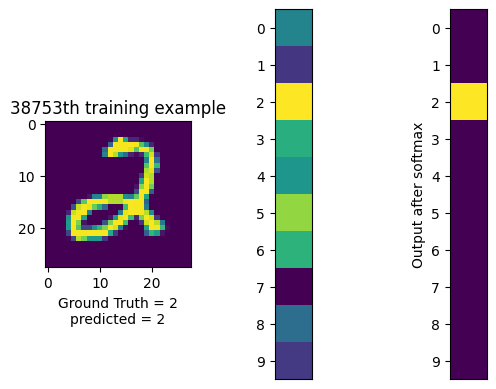

Logits output =  [  5.86731351 -37.57815588  86.29753921  31.86144617  16.59334292
  62.49923241  34.45820761 -60.69486928  -7.80949204 -35.56311879]
Softmax output =  [1.17380729e-35 1.59026383e-54 1.00000000e+00 2.28404773e-24
 5.34382446e-31 4.61877362e-11 3.06523898e-23 1.45213874e-64
 1.34845239e-41 1.19285778e-53]
Loss value for this example =  -194829.16235353207

======= Epoch : 5 =======
Initial Loss = 44044.44495627381
4000
Loss after training = 34784.422328382454


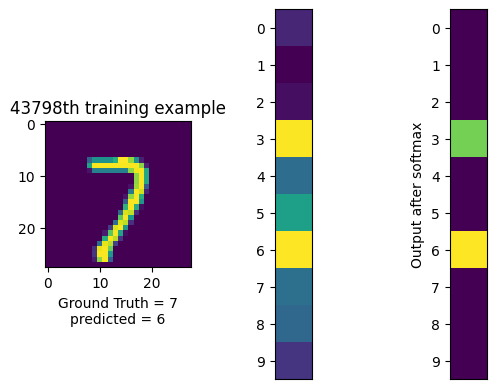

Logits output =  [-19.2201629  -24.60120358 -22.82050357  24.95781922  -6.75129411
   3.47404601  25.19360058  -6.12302166  -8.05781662 -17.20519053]
Softmax output =  [2.87412652e-20 1.32296882e-22 7.85050867e-22 4.41326228e-01
 7.47595694e-15 2.06288769e-10 5.58673772e-01 1.40127074e-14
 2.02419001e-15 2.15574437e-19]
Loss value for this example =  -76918.99553830108

======= Epoch : 6 =======
Initial Loss = 34784.422328382454
5000
Loss after training = 22613.672840093684

======= Epoch : 7 =======
Initial Loss = 22613.672840093684
6000
Loss after training = 14846.126840821098


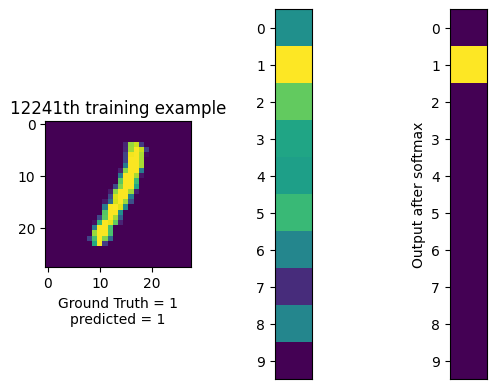

Logits output =  [  1.43226707  43.86564339  23.46813889   8.81744358   7.00169527
  16.39628213  -2.00136125 -30.18747633  -1.94920984 -41.09617709]
Softmax output =  [3.72751000e-19 9.99999999e-01 1.38508476e-09 6.00841916e-16
 9.77666541e-17 1.17546035e-12 1.20285418e-20 6.90460342e-33
 1.26724928e-20 1.26342712e-37]
Loss value for this example =  -105291.84295580254

======= Epoch : 8 =======
Initial Loss = 14846.126840821098
7000
Loss after training = 14689.566757593095

======= Epoch : 9 =======
Initial Loss = 14689.566757593095
8000
Loss after training = 13790.805375235828

======= Epoch : 10 =======
Initial Loss = 13790.805375235828
9000
Loss after training = 12117.131917766976


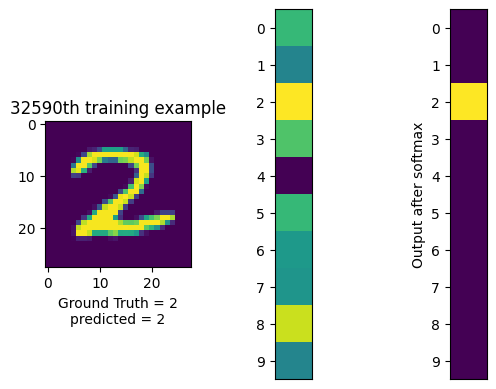

Logits output =  [  1.21419341 -23.74820723  38.61806673   7.33380917 -75.25355934
   0.82928475 -14.15904939 -16.03303767  29.69487361 -23.63849425]
Softmax output =  [5.69700163e-17 8.21511202e-28 9.99866756e-01 2.59036939e-14
 3.51660251e-50 3.87688250e-17 1.19986346e-23 1.84191276e-24
 1.33244286e-04 9.16771771e-28]
Loss value for this example =  -117176.32649209812

======= Epoch : 11 =======
Initial Loss = 12117.131917766976
10000
Loss after training = 11029.135032284481

======= Epoch : 12 =======
Initial Loss = 11029.135032284481
11000
Loss after training = 10097.014254225924

======= Epoch : 13 =======
Initial Loss = 10097.014254225924
12000
Loss after training = 10955.363652623906

======= Epoch : 14 =======
Initial Loss = 10955.363652623906
13000
Loss after training = 10682.048954471036


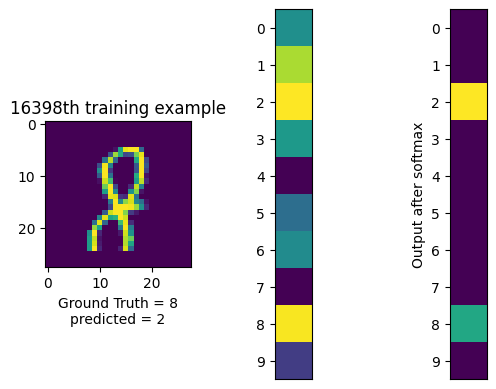

Logits output =  [-11.03526632   9.37691292  16.33483182  -8.77186471 -38.16895828
 -18.49782063 -11.91862129 -38.1509681   15.82221326 -28.18169513]
Softmax output =  [8.11392539e-13 5.94467092e-04 6.25048334e-01 7.80214179e-12
 1.33419195e-24 4.65891572e-16 3.35424530e-13 1.35841151e-24
 3.74357199e-01 2.90156027e-20]
Loss value for this example =  -69747.22677751079

======= Epoch : 15 =======
Initial Loss = 10682.048954471036
14000
Loss after training = 11758.687468358352

======= Epoch : 16 =======
Initial Loss = 11758.687468358352
15000


In [12]:
examples = 10
epochs = 40
last_epoch = -1
learning_rate = 0.01
for epoch in range(epochs):
    print(f"\n======= Epoch : {epoch+1} =======")
    print(f"Initial Loss = {MnistClassificationModel.get_loss()}")
    MnistClassificationModel.reset_gradient()
    batchx, batchy = batch_generator_1000()
    for tx, ty in zip(batchx, batchy):
        MnistClassificationModel.see_dataset_for_training(tx, ty)
        
    MnistClassificationModel.make_model_learn(learning_rate/1000)
    print(f"Loss after training = {MnistClassificationModel.get_loss()}")
    losses.append(MnistClassificationModel.get_loss())

    log_epoch = np.floor(np.log(epoch + 1)/np.log(epochs)*examples)
    if log_epoch != last_epoch:
        model_tester(print_outputs=True)
    last_epoch = log_epoch


In [ ]:
plt.plot(losses)
plt.savefig("Loss-graph.png")

In [ ]:
def choose_random_test():
    limit = len(testy)
    random_number = np.random.randint(0, limit)
    sample_X = testx[random_number]
    sample_y = testy[random_number]
    return sample_X, sample_y, random_number
    
def choose_random_and_test_model(log_output=True):
    xx, yy, n = choose_random_test()
    prediction = MnistClassificationModel(xx)
    prediction_number = np.argmax(prediction)

    correct = prediction_number == yy
    colour = 'blue' if correct else 'red'
    plt.imshow(xx, cmap="Blues")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"Ground Truth = {yy}\nPrediction = {prediction_number}", color=colour)
    plt.title(f"{n}th test dataset\n")
    return np.reshape(prediction, (-1,1))
    
choose_random_and_test_model() 

In [ ]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,10, i*2+1)
    prediction = choose_random_and_test_model()

    plt.subplot(5, 10, i*2+2)
    plt.imshow(prediction, cmap='Blues')
    plt.yticks(np.arange(10))
    plt.xticks([])

plt.savefig("Output.png")
    